# Exploration of expression data for Tabula Sapiens

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [2]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2
import scanpy as sc

## 1.2 Load Tabula Sapiens data

In [3]:
#load adata for Tabula Sapiens
all_cells_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

# 2. Pancreas
# 2.1 Filtering pancreas data and processing

In [4]:
#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
#processing exocrine and endocrine pancreas count data
exo_pancreas = pd.DataFrame.sparse.from_spmatrix(exo_pancreas_adata.X)
exo_pancreas = np.expm1(exo_pancreas)
exo_pancreas = exo_pancreas.sparse.to_dense()
exo_pancreas = exo_pancreas.set_axis(exo_pancreas_adata.var.index.values, axis = 1)
exo_pancreas.insert(0, 'cell_type', exo_pancreas_adata.obs['cell_ontology_class'].values)


endo_pancreas = pd.DataFrame.sparse.from_spmatrix(endo_pancreas_adata.X)
endo_pancreas = np.expm1(endo_pancreas)
endo_pancreas = endo_pancreas.sparse.to_dense()
endo_pancreas = endo_pancreas.set_axis(endo_pancreas_adata.var.index.values, axis = 1)
endo_pancreas.insert(0, 'cell_type', endo_pancreas_adata.obs['cell_ontology_class'].values)

In [7]:
print(f'Exocrine pancreas has {len(exo_pancreas)} cells. Endocrine pancreas has {len(endo_pancreas)} cells.')

Exocrine pancreas has 11977 cells. Endocrine pancreas has 1520 cells.


## 2.2 Plot boxplots of insulin expression across cell types in endocrine and exocrine pancreas
### 2.2.1 Endocrine pancreas

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

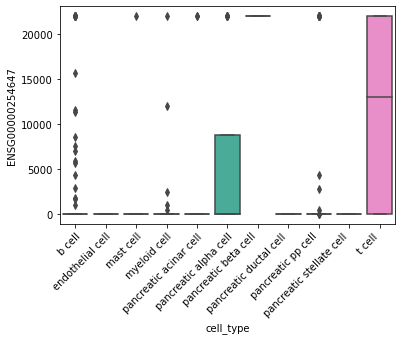

In [145]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = endo_pancreas, x = 'cell_type', y = 'ENSG00000254647')

### 2.2.2 Exocrine pancreas

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

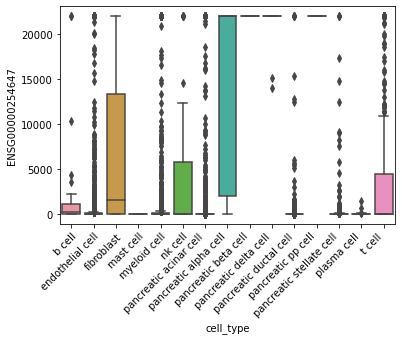

In [146]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = exo_pancreas, x = 'cell_type', y = 'ENSG00000254647')

## 2.3 Plot insulin expression distribution across all cells in the endocrine and exocrine pancreas
### 2.3.1 Endocrine pancreas

<AxesSubplot:ylabel='Frequency'>

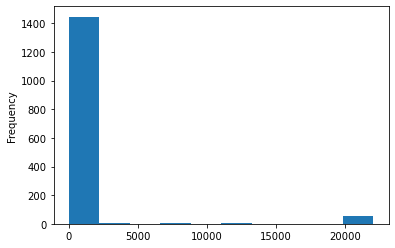

In [156]:
endo_pancreas['ENSG00000254647'].plot.hist()

In [167]:
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] > 15000].unique()

array([22025.465, 15697.833], dtype=float32)

What is bizarre, is that there are 57 cells with the same expression of 22025.465 CPM.

In [170]:
endo_pancreas[endo_pancreas['ENSG00000254647'] == 22025.465]

,cell_type,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000284332,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
897,t cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,7.747590,0.000000,0.0,0.0,6.895751,0.000000,0.000000,30.443871,0.0,0.000000
898,t cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,6.890925,0.000000,0.0,0.0,0.000000,0.000000,0.000000,22.355555,0.0,0.000000
899,b cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,23.509539,0.000000,0.0,0.0,8.325865,0.000000,0.000000,44.097183,0.0,0.000000
901,b cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,12.149282,0.000000,0.0,0.0,0.000000,5.545619,0.000000,25.522171,0.0,0.000000
903,mast cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,38.984898,0.000000,0.0,0.0,12.769271,0.000000,0.000000,54.029964,0.0,0.000000
904,t cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,17.144512,0.000000,0.0,0.0,6.845606,4.269014,0.000000,17.640930,0.0,0.000000
905,b cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,21.183891,0.000000,0.0,0.0,4.017620,3.636397,0.000000,37.347923,0.0,0.000000
906,pancreatic beta cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,203.510162,0.000000,0.0,0.0,87.896942,9.601280,0.000000,387.980652,0.0,16.275061
909,b cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,33.296047,370.795532,0.0,0.0,9.511099,0.000000,0.000000,33.615696,0.0,0.000000
914,t cell,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,21.439598,0.000000,0.0,0.0,9.620581,0.000000,0.000000,64.120720,0.0,0.000000


These 57 cells however are not all the same cell type making it unlikely it is a duplicate. This could be due to technical errors in the limitation of detection of the read counts and when normalising and scaling they reduced the real read counts which were higher to a lower value?

In [178]:
endo_pancreas['ENSG00000254647'][(endo_pancreas['ENSG00000254647'] >4000 ) & (endo_pancreas['ENSG00000254647'] < 15000)].sort_values()

945      4007.911865
932      4322.045898
997      4356.529785
913      5615.633301
902      5843.714844
954      6966.125488
900      7558.000977
924      8545.727539
1068     8804.474609
911     11334.809570
936     11523.946289
923     12024.778320
Name: ENSG00000254647, dtype: float32

<AxesSubplot:ylabel='Frequency'>

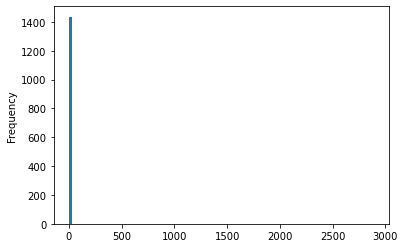

In [184]:
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] <= 4000].plot.hist(bins = 100)

Below, 4000 CPM nearly all the counts are 0 CPM for insulin.

**Ignoring the massive amount of zero counts**

<AxesSubplot:ylabel='Frequency'>

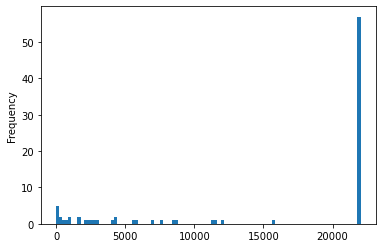

In [188]:
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] > 0].plot.hist(bins = 100)

### 2.3.2 Exocrine pancreas

<AxesSubplot:ylabel='Frequency'>

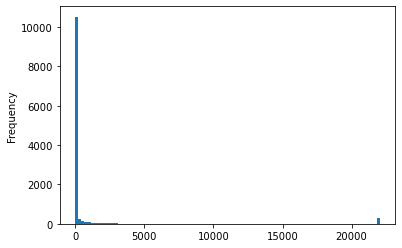

In [152]:
exo_pancreas['ENSG00000254647'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

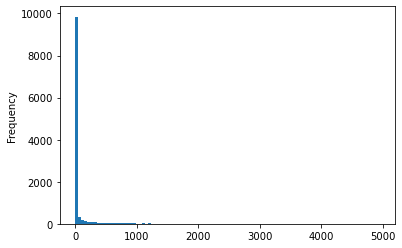

In [187]:
exo_pancreas['ENSG00000254647'][exo_pancreas['ENSG00000254647'] < 5000].plot.hist(bins = 100)

**Ignoring the massive amount of zero counts**

<AxesSubplot:ylabel='Frequency'>

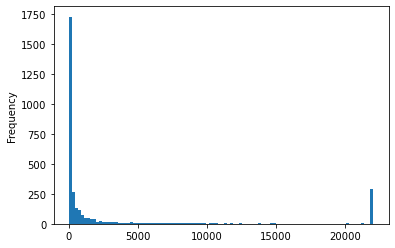

In [189]:
exo_pancreas['ENSG00000254647'][exo_pancreas['ENSG00000254647'] > 0].plot.hist(bins = 100)

## 2.4 Plot insulin expression distribution across cells for pancreas (cell type coloured)
### 2.4.1 Endocrine pancreas

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

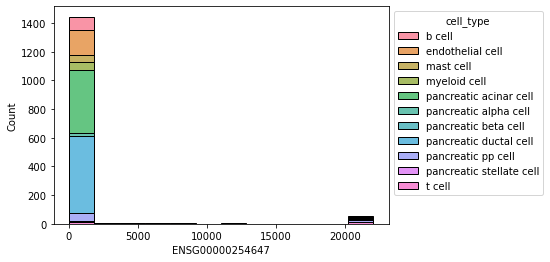

In [28]:
ax = sns.histplot(data = endo_pancreas, x = 'ENSG00000254647', hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

This shows the number of cells in a cell type with the expression count for insulin. Here we see the expression is dominated by zero so what does it look like if we remove it.

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

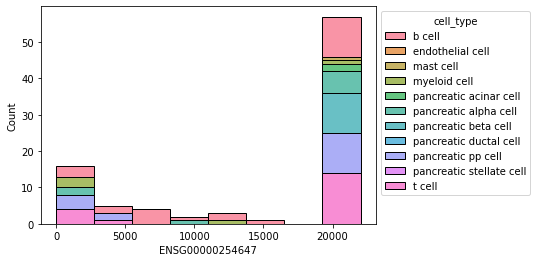

In [29]:
ax = sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', hue = 'cell_type',
                  multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Removing the zero expression values reveal populations of cells of different cell types with a near zero expression and a large group of cell types with a high insulin expression (namely b cells, t cells, pancreatic beta cells, pancreatic pp cells and alpha cells) as shown by the stacked boxes. 

By removing the zero expression we can also log tranform the scale to see that the majority of expressions above the zero count have a magnitude in the thousands/tens of thousands.

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

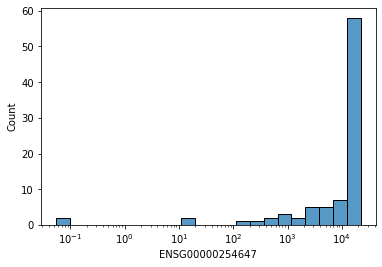

In [31]:
sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True)

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

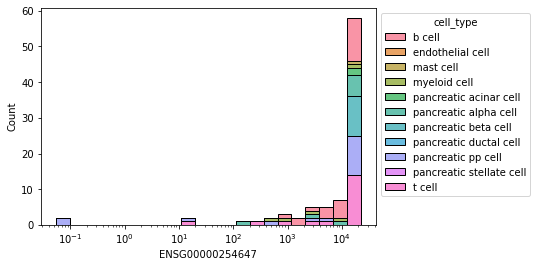

In [33]:
ax = sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True, 
             hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Again we see that the higher expressions fall across most cell types and does not appear to be exclusive to just one.

### 2.4.2 Exocrine pancreas

**Remove zero counts to see expressions better**

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

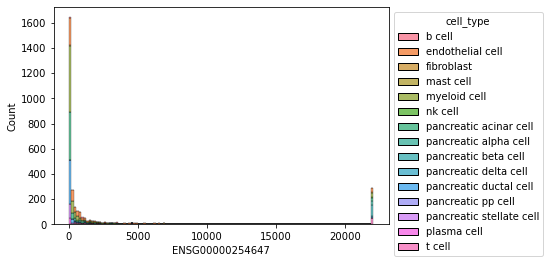

In [41]:
ax = sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', hue = 'cell_type',
                  multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

The histogram above shows that the majority of cells have an expression close to zero but some cell types exhibit a high expression however, this is not as significant as the smaller expressions.

**Log scale the expression axis to see histogram better**

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

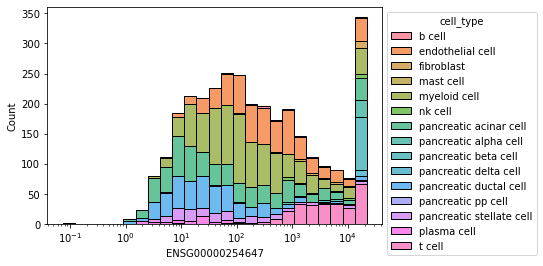

In [47]:
ax = sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True, 
             hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

This shows that apart from the highest expression of the insulin and zero counts the expression follows a roughly normal distribution over all cells however, the individual cell types have different distributions.

## 2.5 Plot insulin expression distribution across cells within pancreas cell types

### 2.5.1 Endocrine pancreas

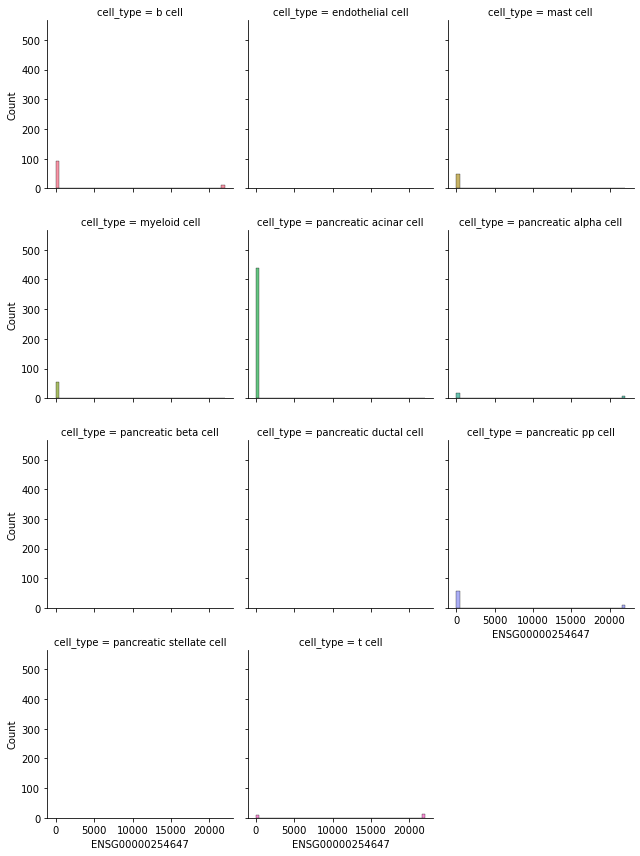

In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

g = sns.FacetGrid(data = endo_pancreas, col = 'cell_type', col_wrap = 3, hue = 'cell_type')
g.map_dataframe(sns.histplot, x = 'ENSG00000254647', bins = 50)

**Remove zero expression counts as these are overshadowing the other counts**

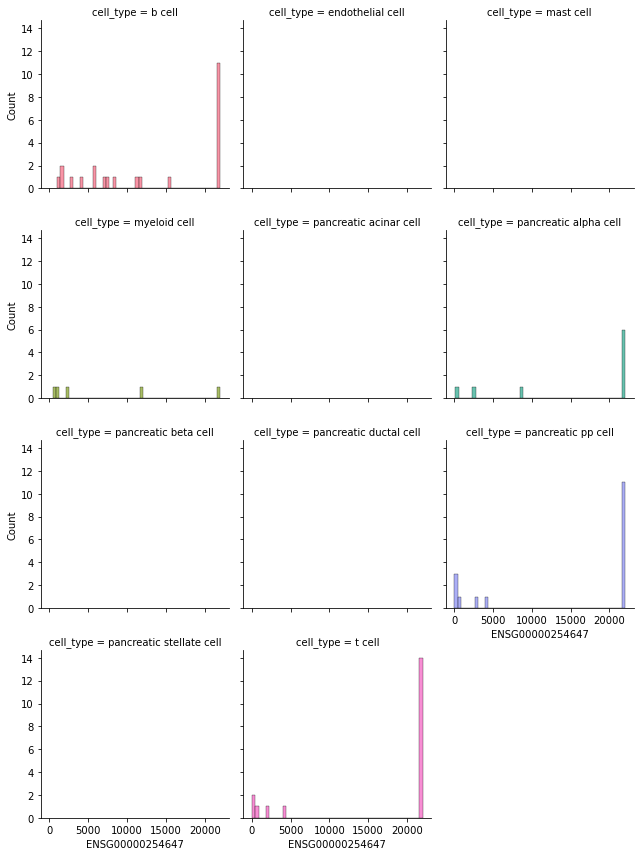

In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

g = sns.FacetGrid(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], col = 'cell_type', col_wrap = 3, hue = 'cell_type')
g.map_dataframe(sns.histplot, x = 'ENSG00000254647', bins = 50)

**Still there appears to be overshadowing of some cells expressions so will use separate plots**

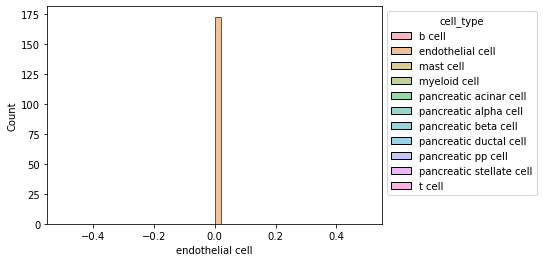

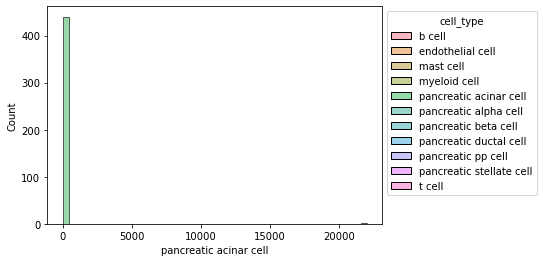

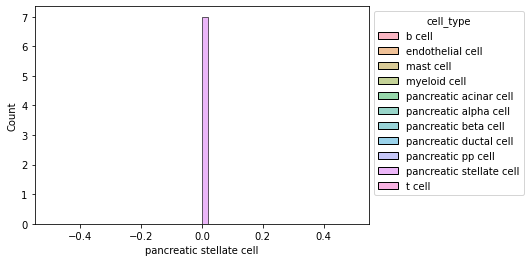

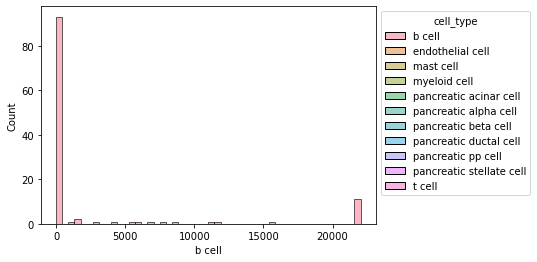

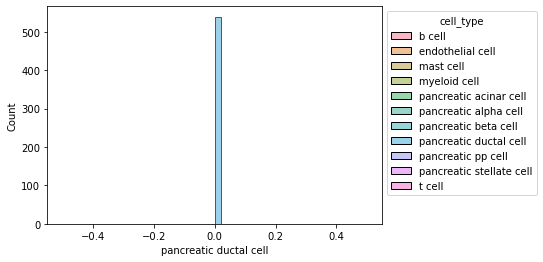

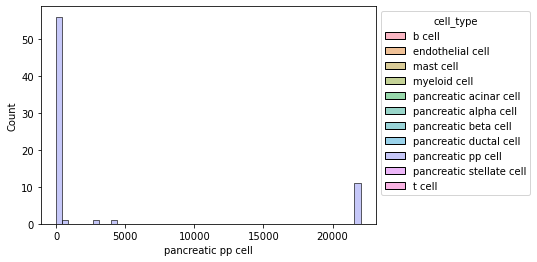

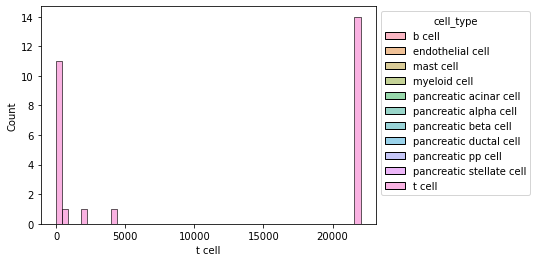

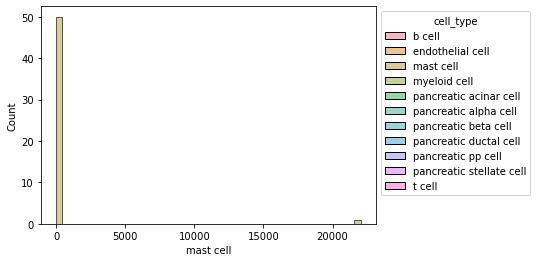

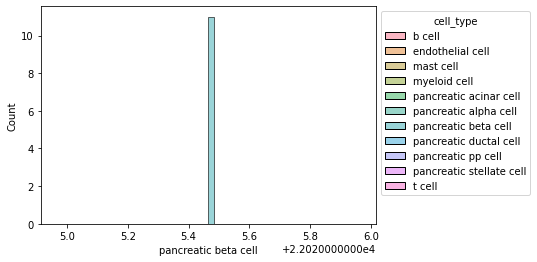

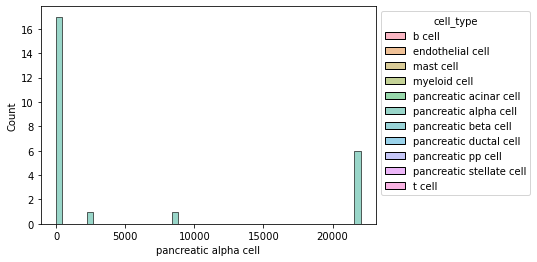

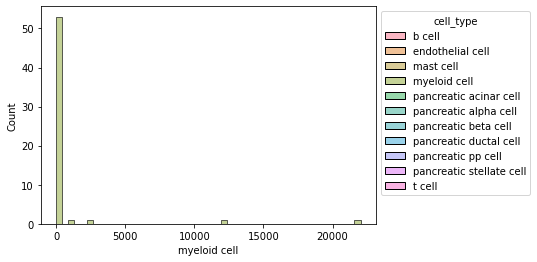

In [74]:
for i in endo_pancreas.cell_type.unique():
    ax = sns.histplot(data = endo_pancreas[endo_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 50, hue = 'cell_type')
    #move figure legend outside of the plot
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.xlabel(i)
    plt.show()

We see that endothelial cells, and pancreatic ductal and stellate cells only have zero expression for insulin gene. The others appear to have cells with high zero expressions but some cells with a non-zero expression too.

### 2.5.2 Exocrine pancreas

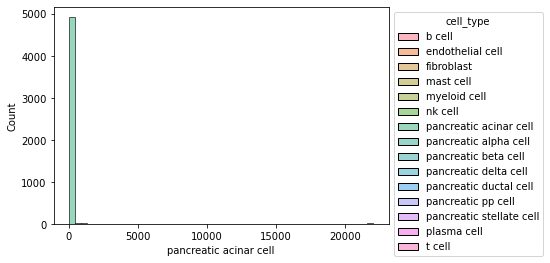

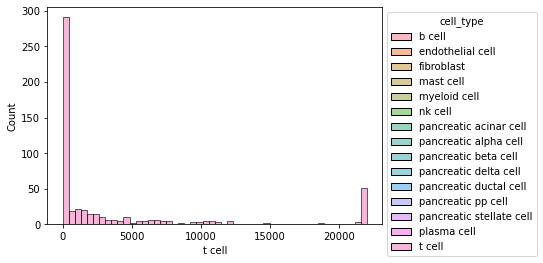

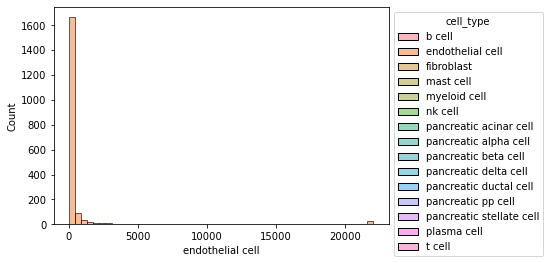

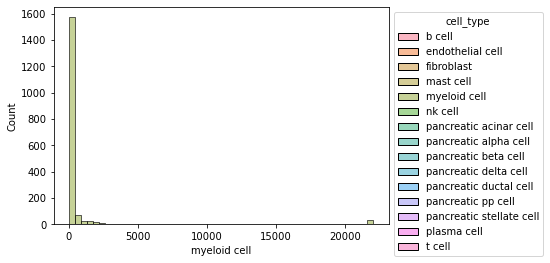

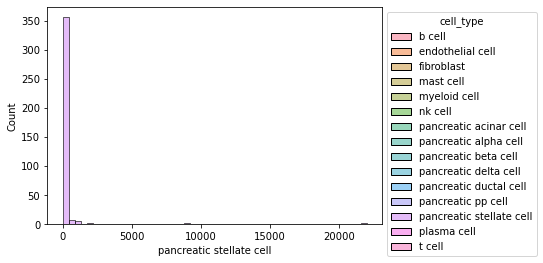

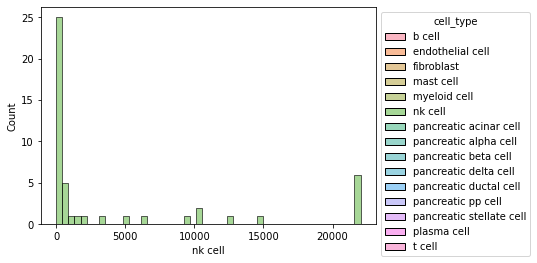

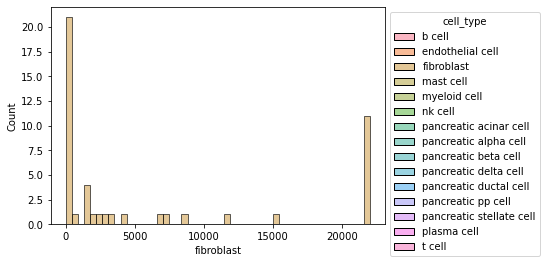

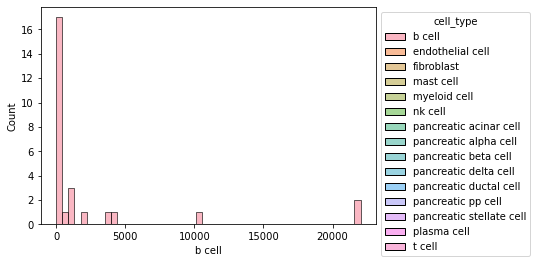

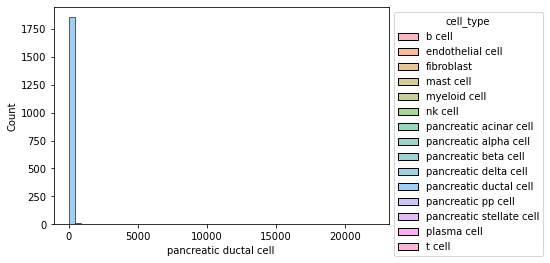

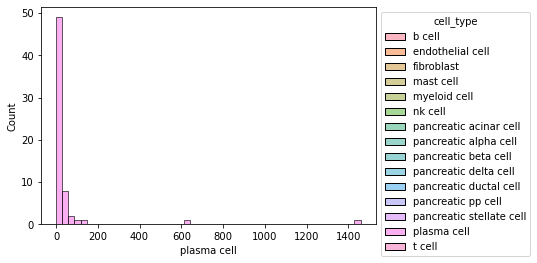

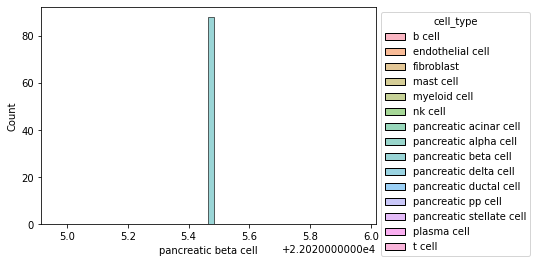

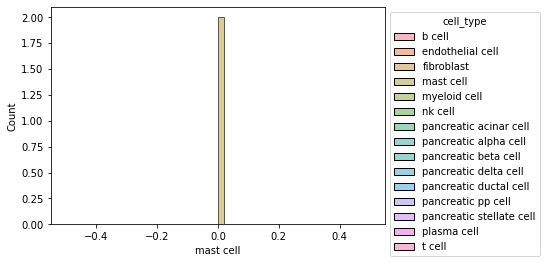

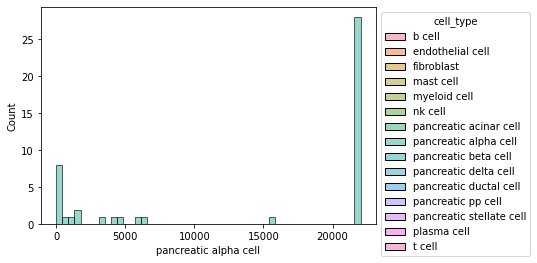

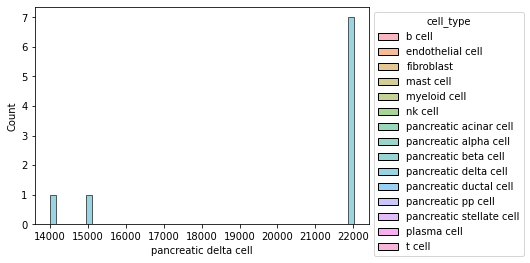

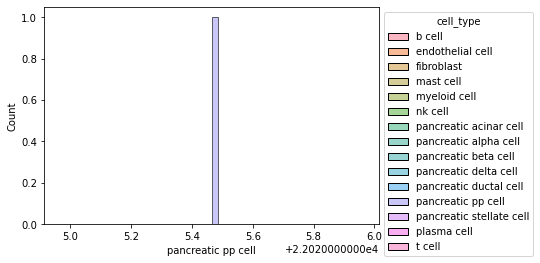

In [85]:
for i in exo_pancreas.cell_type.unique():
    ax = sns.histplot(data = exo_pancreas[exo_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 50, hue = 'cell_type')
    #move figure legend outside of the plot
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.xlabel(i)
    plt.show()

The islets of Langerhans where we expect insulin secretion in the pancreas consists of alpha, beta, delta and pp cells; it is known that the beta cells secrete insulin so this could be inaccurate sorting of cells that we're seeing resulting in other cell types from the islets of Langerhans to appear to have high insulin expression.